In [1]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
import math
import itertools
import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
hyperparameter_log_path = "Notebook/Arif's Workspace/Hyperparameter Tuning/Log/Merged"
data_version = "Trained_V2-2.csv"
hyperparameter_log = "V5.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


# Check Hyperparameter Log

In [37]:
hp_log = pd.read_csv(os.path.join(drive_path, hyperparameter_log_path+"/"+hyperparameter_log))

hp_log['convolution_hyperparameter'].replace(r"<class '(.*?)'>", r"\1", regex=True)
hp_log['dense_hyperparameter'].replace(r"<class '(.*?)'>", r"\1", regex=True)
hp_log = hp_log.drop_duplicates(subset=['convolution_part', 'convolution_hyperparameter', 'dense_part', 'dense_hyperparameter'])
hp_log

,convolution_part,convolution_hyperparameter,dense_part,dense_hyperparameter,input_shape,layer_metadata,duration,loss,accuracy,f1score,...,accuracy_optimal_threshold,f1score_optimal_threshold,auc_optimal_threshold,train_loss,train_accuracy,train_f1score,train_auc,train_accuracy_optimal_threshold,train_f1score_optimal_threshold,train_auc_optimal_threshold
0,"['maxpooling1d', 'maxpooling1d', 'conv1d', 'ma...","[{'pool_size': 2}, {'pool_size': 2}, {'filters...","['dense', 'dense']","[{'units': 64, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",137.489117,0.327290,0.896923,0.918001,...,0.709808,0.798620,0.727389,0.141809,0.896923,0.947437,0.947479,0.953319,0.953318,0.953319
1,"['conv1d', 'maxpooling1d', 'conv1d', 'maxpooli...","[{'filters': 16, 'kernel_size': 3, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 8, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",163.276878,0.227107,0.940383,0.942274,...,0.788287,0.853382,0.801970,0.040699,0.940383,0.985712,0.985713,0.988011,0.988011,0.988011
2,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 2, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 128, 'activation': 'relu'}, {'units...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",169.747137,0.432074,0.945051,0.944520,...,0.720424,0.807755,0.753281,0.041204,0.945051,0.988396,0.988412,0.995806,0.995806,0.995806
3,"['maxpooling1d', 'conv1d', 'conv1d', 'conv1d']","[{'pool_size': 2}, {'filters': 4, 'kernel_size...","['dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",154.931892,0.251962,0.923681,0.934285,...,0.774464,0.844503,0.764690,0.116177,0.923681,0.962377,0.962397,0.970591,0.970590,0.970591
4,"['maxpooling1d', 'conv1d', 'conv1d', 'maxpooli...","[{'pool_size': 2}, {'filters': 8, 'kernel_size...","['dense', 'dense', 'dense']","[{'units': 32, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",164.081831,0.298141,0.924758,0.934255,...,0.753988,0.830699,0.755942,0.061282,0.924758,0.979691,0.979695,0.984378,0.984378,0.984378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 64, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",182.491993,0.374224,0.944873,0.944607,...,0.808579,0.866769,0.810548,0.005199,0.944873,0.998229,0.998229,0.998664,0.998664,0.998664
787,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 2, 'activation'...","['dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",161.812749,0.210981,0.945411,0.945234,...,0.791519,0.855473,0.812966,0.066044,0.945411,0.978806,0.978812,0.982542,0.982542,0.982542
788,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 8, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",164.977893,0.320304,0.940922,0.942858,...,0.808222,0.866689,0.795672,0.041132,0.940922,0.985825,0.985829,0.988689,0.988689,0.988689
789,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 8, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 64, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",162.285817,0.407709,0.943617,0.944485,...,0.778590,0.847048,0.813610,0.005218,0.943617,0.998262,0.998262,0.998821,0.998821,0.998821


In [38]:
hp_log['avg_metrics'] = (0.8*hp_log['accuracy'] + 0.05*hp_log['f1score'] + 0.15*hp_log['auc'])

hp_log_sorted = hp_log.copy()
hp_log_sorted = hp_log_sorted.sort_values(by=['avg_metrics', 'accuracy_optimal_threshold', 'f1score_optimal_threshold', 'auc_optimal_threshold'], ascending=[False, False, False, False])

hp_log_sorted

,convolution_part,convolution_hyperparameter,dense_part,dense_hyperparameter,input_shape,layer_metadata,duration,loss,accuracy,f1score,...,f1score_optimal_threshold,auc_optimal_threshold,train_loss,train_accuracy,train_f1score,train_auc,train_accuracy_optimal_threshold,train_f1score_optimal_threshold,train_auc_optimal_threshold,avg_metrics
229,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 3, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 32, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",289.202970,0.359867,0.949182,0.948547,...,0.853855,0.824489,0.011519,0.949182,0.995903,0.995903,0.997425,0.997425,0.997425,0.899668
674,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",169.262552,0.255048,0.944155,0.946426,...,0.834668,0.791258,0.047206,0.944155,0.984092,0.984094,0.987702,0.987702,0.987702,0.898971
694,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 8, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 128, 'activation': 'relu'}, {'units...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",167.011725,0.492458,0.947028,0.947369,...,0.846127,0.807146,0.000774,0.947028,0.999814,0.999814,0.999907,0.999907,0.999907,0.898758
687,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 32, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 32, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",175.617774,0.383692,0.947925,0.947331,...,0.869344,0.827242,0.005629,0.947925,0.997986,0.997986,0.998543,0.998543,0.998543,0.898628
181,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 3, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 64, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",299.341189,0.460542,0.947208,0.947306,...,0.853576,0.797117,0.006487,0.947208,0.998600,0.998600,0.998693,0.998693,0.998693,0.898565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,"['conv1d', 'maxpooling1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 16, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",210.967824,0.560997,0.713727,0.705691,...,0.875702,0.630369,0.355836,0.713727,0.663533,0.746867,0.747982,0.664725,0.747982,0.693439
182,"['conv1d', 'conv1d', 'conv1d']","[{'filters': 8, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 128, 'activation': 'relu'}, {'units...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",251.484915,0.555254,0.716245,0.707193,...,0.894757,0.655434,0.183892,0.716245,0.831284,0.872950,0.872950,0.831284,0.872950,0.692626
458,"['maxpooling1d', 'conv1d', 'conv1d', 'conv1d']","[{'pool_size': 2}, {'filters': 16, 'kernel_siz...","['dense', 'dense', 'dense', 'dense']","[{'units': 16, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",175.118809,0.427405,0.705652,0.703191,...,0.875439,0.717877,0.208194,0.705652,0.823026,0.864692,0.865158,0.823492,0.865158,0.690772
570,"['conv1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 2, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",169.548396,0.393653,0.703852,0.702626,...,0.885572,0.731556,0.231583,0.703852,0.815903,0.857577,0.864293,0.822626,0.864293,0.690542


In [39]:
# Top 5 Model
hp_log_sorted = hp_log_sorted.sort_values(by=['avg_metrics', 'accuracy_optimal_threshold', 'f1score_optimal_threshold', 'auc_optimal_threshold'], ascending=[False, False, False, False])

for i in range(5):
  print("Best Model #", i+1)
  print("-"*10)
  pprint.pprint(hp_log_sorted.iloc[i].to_dict())
  print("-"*10)

Best Model # 1
----------
{'accuracy': 0.9491823613643646,
 'accuracy_optimal_threshold': 0.7886475429281052,
 'auc': 0.619298226299561,
 'auc_optimal_threshold': 0.8244889651795486,
 'avg_metrics': 0.8996679817135488,
 'convolution_hyperparameter': "[{'filters': 16, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 16, "
                               "'kernel_size': 3, 'activation': 'relu'}, "
                               "{'filters': 16, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 32, "
                               "'kernel_size': 2, 'activation': 'relu'}]",
 'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
 'dense_hyperparameter': "[{'units': 32, 'activation': 'relu'}, {'units': 8, "
                         "'activation': 'relu'}, {'units': 128, 'activation': "
                         "'relu'}, {'units': 32, 'activation': 'relu'}]",
 'dense_part': "['dense', 'dense', 'dense', 'dense

In [40]:
# Bottom 5 Model
hp_log_sorted = hp_log_sorted.sort_values(by=['avg_metrics', 'accuracy_optimal_threshold', 'f1score_optimal_threshold', 'auc_optimal_threshold'], ascending=[False, False, False, False])

for i in range(5):
  print("Worst Model #", i+1)
  print("-"*10)
  pprint.pprint(hp_log_sorted.iloc[i].to_dict())
  print("-"*10)

Worst Model # 1
----------
{'accuracy': 0.9491823613643646,
 'accuracy_optimal_threshold': 0.7886475429281052,
 'auc': 0.619298226299561,
 'auc_optimal_threshold': 0.8244889651795486,
 'avg_metrics': 0.8996679817135488,
 'convolution_hyperparameter': "[{'filters': 16, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 16, "
                               "'kernel_size': 3, 'activation': 'relu'}, "
                               "{'filters': 16, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 32, "
                               "'kernel_size': 2, 'activation': 'relu'}]",
 'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
 'dense_hyperparameter': "[{'units': 32, 'activation': 'relu'}, {'units': 8, "
                         "'activation': 'relu'}, {'units': 128, 'activation': "
                         "'relu'}, {'units': 32, 'activation': 'relu'}]",
 'dense_part': "['dense', 'dense', 'dense', 'dens

In [41]:
hp_log_sorted['avg_metrics_optimal_threshold']  = (0.34*hp_log['accuracy_optimal_threshold'] + 0.33*hp_log['f1score_optimal_threshold'] + 0.33*hp_log['auc_optimal_threshold'])
hp_log

hp_log_sorted = hp_log_sorted.sort_values(by=['avg_metrics_optimal_threshold'], ascending=[False])
hp_log_sorted

,convolution_part,convolution_hyperparameter,dense_part,dense_hyperparameter,input_shape,layer_metadata,duration,loss,accuracy,f1score,...,auc_optimal_threshold,train_loss,train_accuracy,train_f1score,train_auc,train_accuracy_optimal_threshold,train_f1score_optimal_threshold,train_auc_optimal_threshold,avg_metrics,avg_metrics_optimal_threshold
437,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 8, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",172.968316,0.249681,0.939665,0.941534,...,0.792644,0.049729,0.939665,0.984193,0.984194,0.986926,0.986926,0.986926,0.888257,0.850246
769,"['conv1d', 'conv1d', 'maxpooling1d', 'conv1d']","[{'filters': 8, 'kernel_size': 2, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 8, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",163.508215,0.268803,0.932483,0.939172,...,0.814233,0.042504,0.932483,0.985913,0.985915,0.989942,0.989942,0.989942,0.888983,0.837784
687,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 32, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 32, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",175.617774,0.383692,0.947925,0.947331,...,0.827242,0.005629,0.947925,0.997986,0.997986,0.998543,0.998543,0.998543,0.898628,0.836072
404,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 32, 'kernel_size': 3, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",177.137972,0.228179,0.946310,0.943789,...,0.813649,0.041973,0.946310,0.986075,0.986078,0.987633,0.987633,0.987633,0.889632,0.835769
210,"['conv1d', 'conv1d', 'conv1d', 'conv1d']","[{'filters': 16, 'kernel_size': 2, 'activation...","['dense', 'dense', 'dense', 'dense']","[{'units': 4, 'activation': 'relu'}, {'units':...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",254.341595,0.296549,0.933921,0.938897,...,0.775033,0.041425,0.933921,0.985992,0.985993,0.988478,0.988478,0.988478,0.886256,0.835756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,"['conv1d', 'maxpooling1d', 'conv1d', 'conv1d']","[{'filters': 4, 'kernel_size': 3, 'activation'...","['dense', 'dense', 'dense', 'dense']","[{'units': 32, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",172.717325,0.415481,0.932481,0.937529,...,0.727554,0.036154,0.932481,0.987922,0.987923,0.991400,0.991400,0.991400,0.882909,0.740916
647,"['maxpooling1d', 'conv1d', 'conv1d', 'conv1d']","[{'pool_size': 2}, {'filters': 16, 'kernel_siz...","['dense', 'dense', 'dense', 'dense']","[{'units': 128, 'activation': 'relu'}, {'units...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",172.153696,0.434558,0.934280,0.938625,...,0.715683,0.013859,0.934280,0.995715,0.995715,0.996428,0.996428,0.996428,0.885727,0.738856
72,"['maxpooling1d', 'conv1d', 'conv1d', 'conv1d']","[{'pool_size': 2}, {'filters': 4, 'kernel_size...","['dense', 'dense', 'dense', 'dense']","[{'units': 128, 'activation': 'relu'}, {'units...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",161.358655,0.411237,0.937332,0.940133,...,0.710352,0.009934,0.937332,0.996894,0.996894,0.997142,0.997142,0.997142,0.887045,0.738290
37,"['maxpooling1d', 'conv1d', 'conv1d', 'conv1d']","[{'pool_size': 2}, {'filters': 4, 'kernel_size...","['dense', 'dense', 'dense']","[{'units': 64, 'activation': 'relu'}, {'units'...","(85, 1)","[{'layer': 'conv1d', 'hyperparameter': [{'para...",151.892055,0.373305,0.936970,0.940990,...,0.704586,0.017923,0.936970,0.993507,0.993507,0.995030,0.995030,0.995030,0.889258,0.738246


In [42]:
# Top 5 Model

for i in range(5):
  print("Best Model #", i+1)
  print("-"*10)
  pprint.pprint(hp_log_sorted.iloc[i].to_dict())
  print("-"*10)

Best Model # 1
----------
{'accuracy': 0.9396653473377228,
 'accuracy_optimal_threshold': 0.8594108421830003,
 'auc': 0.596320005965686,
 'auc_optimal_threshold': 0.7926442452781064,
 'avg_metrics': 0.888256981387852,
 'avg_metrics_optimal_threshold': 0.8502463030358922,
 'convolution_hyperparameter': "[{'filters': 4, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 32, "
                               "'kernel_size': 2, 'activation': 'relu'}, "
                               "{'filters': 8, 'kernel_size': 2, 'activation': "
                               "'relu'}, {'filters': 8, 'kernel_size': 3, "
                               "'activation': 'relu'}]",
 'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
 'dense_hyperparameter': "[{'units': 8, 'activation': 'relu'}, {'units': 8, "
                         "'activation': 'relu'}, {'units': 4, 'activation': "
                         "'relu'}, {'units': 16, 'activation': 'relu'}]",
 'd

In [43]:
# Bottom 5 Model

for i in range(5):
  print("Worst Model #", i+1)
  print("-"*10)
  pprint.pprint(hp_log_sorted.iloc[i].to_dict())
  print("-"*10)

Worst Model # 1
----------
{'accuracy': 0.9396653473377228,
 'accuracy_optimal_threshold': 0.8594108421830003,
 'auc': 0.596320005965686,
 'auc_optimal_threshold': 0.7926442452781064,
 'avg_metrics': 0.888256981387852,
 'avg_metrics_optimal_threshold': 0.8502463030358922,
 'convolution_hyperparameter': "[{'filters': 4, 'kernel_size': 3, "
                               "'activation': 'relu'}, {'filters': 32, "
                               "'kernel_size': 2, 'activation': 'relu'}, "
                               "{'filters': 8, 'kernel_size': 2, 'activation': "
                               "'relu'}, {'filters': 8, 'kernel_size': 3, "
                               "'activation': 'relu'}]",
 'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
 'dense_hyperparameter': "[{'units': 8, 'activation': 'relu'}, {'units': 8, "
                         "'activation': 'relu'}, {'units': 4, 'activation': "
                         "'relu'}, {'units': 16, 'activation': 'relu'}]",
 '

In [44]:
# Best Model #1

# {'accuracy': 0.9396653473377228,
#  'accuracy_optimal_threshold': 0.8594108421830003,
#  'auc': 0.596320005965686,
#  'auc_optimal_threshold': 0.7926442452781064,
#  'avg_metrics': 0.888256981387852,
#  'avg_metrics_optimal_threshold': 0.8502463030358922,
#  'convolution_hyperparameter': "[{'filters': 4, 'kernel_size': 3, "
#                                "'activation': 'relu'}, {'filters': 32, "
#                                "'kernel_size': 2, 'activation': 'relu'}, "
#                                "{'filters': 8, 'kernel_size': 2, 'activation': "
#                                "'relu'}, {'filters': 8, 'kernel_size': 3, "
#                                "'activation': 'relu'}]",
#  'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
#  'dense_hyperparameter': "[{'units': 8, 'activation': 'relu'}, {'units': 8, "
#                          "'activation': 'relu'}, {'units': 4, 'activation': "
#                          "'relu'}, {'units': 16, 'activation': 'relu'}]",
#  'dense_part': "['dense', 'dense', 'dense', 'dense']",
#  'f1score': 0.9415340524564156,
#  'f1score_optimal_threshold': 0.8984061083390815,
#  'loss': 0.2496806234121322,
#  'train_accuracy': 0.9396653473377228,
#  'train_accuracy_optimal_threshold': 0.9869262995580108,
#  'train_auc': 0.984194039798882,
#  'train_auc_optimal_threshold': 0.986926299558011,
#  'train_f1score': 0.9841928938315718,
#  'train_f1score_optimal_threshold': 0.986926185005058,
#  'train_loss': 0.0497293006628751}

model = models.Sequential()
model.add(layers.Input(((85, 1))))
model.add(layers.Conv1D(4, 3, activation='relu'))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.Conv1D(8, 2, activation='relu'))
model.add(layers.Conv1D(8, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 83, 4)             16        
                                                                 
 conv1d_5 (Conv1D)           (None, 82, 32)            288       
                                                                 
 conv1d_6 (Conv1D)           (None, 81, 8)             520       
                                                                 
 conv1d_7 (Conv1D)           (None, 79, 8)             200       
                                                                 
 flatten_1 (Flatten)         (None, 632)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 5064      
                                                                 
 dense_6 (Dense)             (None, 8)                

In [45]:
# Best Model #1

# {'accuracy': 0.9396653473377228,
#  'accuracy_optimal_threshold': 0.8594108421830003,
#  'auc': 0.596320005965686,
#  'auc_optimal_threshold': 0.7926442452781064,
#  'avg_metrics': 0.888256981387852,
#  'avg_metrics_optimal_threshold': 0.8502463030358922,
#  'convolution_hyperparameter': "[{'filters': 4, 'kernel_size': 3, "
#                                "'activation': 'relu'}, {'filters': 32, "
#                                "'kernel_size': 2, 'activation': 'relu'}, "
#                                "{'filters': 8, 'kernel_size': 2, 'activation': "
#                                "'relu'}, {'filters': 8, 'kernel_size': 3, "
#                                "'activation': 'relu'}]",
#  'convolution_part': "['conv1d', 'conv1d', 'conv1d', 'conv1d']",
#  'dense_hyperparameter': "[{'units': 8, 'activation': 'relu'}, {'units': 8, "
#                          "'activation': 'relu'}, {'units': 4, 'activation': "
#                          "'relu'}, {'units': 16, 'activation': 'relu'}]",
#  'dense_part': "['dense', 'dense', 'dense', 'dense']",
#  'f1score': 0.9415340524564156,
#  'f1score_optimal_threshold': 0.8984061083390815,
#  'loss': 0.2496806234121322,
#  'train_accuracy': 0.9396653473377228,
#  'train_accuracy_optimal_threshold': 0.9869262995580108,
#  'train_auc': 0.984194039798882,
#  'train_auc_optimal_threshold': 0.986926299558011,
#  'train_f1score': 0.9841928938315718,
#  'train_f1score_optimal_threshold': 0.986926185005058,
#  'train_loss': 0.0497293006628751}

model = models.Sequential()
model.add(layers.Input(((85, 1))))
model.add(layers.Conv1D(4, 3, activation='relu'))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.Conv1D(8, 2, activation='relu'))
model.add(layers.Conv1D(8, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 83, 4)             16        
                                                                 
 conv1d_9 (Conv1D)           (None, 82, 32)            288       
                                                                 
 conv1d_10 (Conv1D)          (None, 81, 8)             520       
                                                                 
 conv1d_11 (Conv1D)          (None, 79, 8)             200       
                                                                 
 flatten_2 (Flatten)         (None, 632)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 5064      
                                                                 
 dense_11 (Dense)            (None, 8)                

<Axes: xlabel='duration', ylabel='Count'>

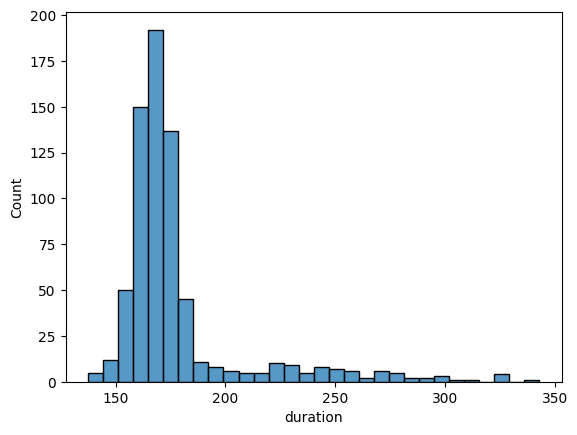

In [46]:
import seaborn as sns

sns.histplot(data=hp_log[hp_log['duration'] < 400], x='duration', bins=30)

In [47]:
hp_log['duration'].sum()/60

2081.6546867330867

In [48]:
hp_log['duration'].mean()/60

2.9780467621360325